# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow

In [3]:
from tqdm.notebook import tqdm
import random
import os
import gc

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.metrics import TrueNegatives, TruePositives, FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [7]:
import warnings
warnings.filterwarnings(action='ignore')

## GPU

GPU (NVIDIA꺼) 사양 확인

In [8]:
!nvidia-smi

Mon May 22 07:07:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

GPU 연결되었는 지 확인

In [9]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Seed

In [10]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f'고정된 Seed : {seed}')

In [11]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'
df = pd.read_csv(path_file)

# Preprocessing

In [14]:
def preprocessing(data, drop=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if drop != None:
    D = ', '.join(drop)
    data = data.drop(columns=drop)
    print(f"훈련에 제외된 변수 들 : {D}")

  return data

In [15]:
df = preprocessing(df)

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')


In [16]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [17]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [18]:
def Rolling_Windows(data, window_size, method, model_name, epochs, batch_size, verbose=False):

  # 출력될 결과물 (DataFrame)
  result_dict = {
      'TRAIN_START_DATE':[], # 훈련 데이터 시작 지점
      'TRAIN_END_DATE':[], # 훈련 데이터 마지막 지점
      'TEST_DATE':[], # 테스트 데이터 지점
      'Actual_POS_WML':[], # 실제 Target 값 (0 or 1)
      f'{model_name}_PROB_POS_WML':[], # 추론된 Target 확률값
      f'{model_name}_PRED_POS_WML':[], # 추론된 Target 값 (0 or 1)
      'loss_binary_crossentropy':[] # 모델 학습 시 사용된 loss 함수 최종 값
  }
  
  # Rolling Window ㅣ실행
  end = data.shape[0] - window_size 

  for i in tqdm(range(end)):
    if i == end:
        print('Prediction using machine learning has ended.')
        break

    # Rolling Fixed Window
    if method == 'Fixed':
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break

    # 테스트 데이터 셋
    test = data.iloc[[window_size+i]]

    # Features / Target 분활 및 array로 변형 
    X_train = train.drop(columns=['pos_wml'])
    X_train = np.array(X_train)

    y_train = train['pos_wml']
    y_train = np.array(y_train)

    X_test = test.drop(columns=['pos_wml'])
    X_test = np.array(X_test)

    y_test = test['pos_wml'] 
    y_test = np.array(y_test)

    # Model Architecture
    MODEL = tf.keras.Sequential([
        Dense(15,activation=LeakyReLU(), input_shape=(len(dynmom.columns)-1,)),
        Dense(1, activation='sigmoid')
    ])

    # Model Architecture Information 출력
    if i == 0:
      print(MODEL.summary())
      print()
      print(plot_model(MODEL, to_file=f'{model_name}_shapes.png', show_shapes=True))
      MODEL_IMG = cv2.imread(f'{model_name}_shapes.png')
      cv2_imshow(MODEL_IMG)
      print()

    # Compile Model
    MODEL.compile(optimizer='adam', # 유명하고 자주쓰는 optimizer 
                  loss='binary_crossentropy', # 이진 분류 시 사용되는 loss 함수
                  metrics=[FalseNegatives(),
                           FalsePositives()]) # 매 epoch 마다 출력되는 성능 지표
                  

    # monitor에 설정된 지표가 일정 epoch 이상 성능 개선이 이루어지지 않으면 모델 학습 멈춤
    early_stopping = EarlyStopping(monitor='loss', patience=20)
    # monitor에 설정된 지표가 일정 epoch 이상 성능 개선이 이루어지지 않으면 learning rate를 값을 낮춤
    reduce_lr = ReduceLROnPlateau(monitor='loss', patience=15, mode='min')

    history = MODEL.fit(X_train, y_train, # 훈련 데이터 Features & Target
                        validation_data=[X_train, y_train], # 검증 데이터 (검증 데이터를 별도로 분류하지 않아서 훈련 데이터로 대체)
                        batch_size=batch_size, # 어느 정도 사이즈의 데이터를 학습하고 모델의 weight를 업데이트 할 것인지 (batch size가 크면 학습 속도 빠르고 이상치에 상대적으로 덜 민감 / 개별 데이터의 특성 덜 반영 그리고 랩 용량 부담)
                        validation_batch_size=batch_size,
                        epochs=epochs, # 동일한 데이터를 몇 번 반복해서 학습할 것인가?
                        shuffle=False, # 훈련 데이터 썩지 않음
                        callbacks=[early_stopping, reduce_lr],
                        verbose=verbose) # 학습 과정 출력 여부
    
    prob_test = MODEL.predict(X_test, # 테스트 데이터 셋
                              #batch_size=batch_size,
                              verbose=verbose) # 학습 과정 출력 여부
    
    pred_test = (prob_test.flatten()>0.5).astype(int) # 모델의 최종 출력값 (확률값)이 threshold 초과할 경우 1
    
    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])
    
    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])

    result_dict['loss_binary_crossentropy'].append(history.history['loss'][-1])

    # Model Reset
    ## 현재 세션에 존재하는 모든 텐서 객체들을 삭제
    ## 메모리 누수(memory leak)를 방지
    ## 모델을 여러 번 훈련할 때 이전에 사용되었던 가중치(weight) 등을 초기화하는 데 사용 
    tf.keras.backend.clear_session()
    gc.collect() # 
    del MODEL


  result = pd.DataFrame(result_dict)
  result = result.set_index('TEST_DATE')

  return result

In [19]:
def cum_return_sharpe_ratio(data, wml, weight):

  # wml 데이터 셋 슬라이싱 (result와 동일한 날짜 맞춤)
  start_index = data.index[0]
  wml = wml.loc[start_index:]

  # 머신러닝 적용되지 않은 경우 Sharpe Ratio
  S_WML = wml.copy()
  w_S = (S_WML['wml'].mean()/S_WML['wml'].std()) * math.sqrt(12)
  print('ORG Sharpe Ratio : {}'.format(w_S))

  # 머신러닝 적용된 경우 Sharpe Ratio
  data[f'for_sharpe_ratio'] = wml['wml'] * data[weight]
  S = (data['for_sharpe_ratio'].mean()/data['for_sharpe_ratio'].std())*math.sqrt(12)
  print('\ML Sharpe Ratio : {}\n'.format(S))
  
  # 머신러닝 적용된 경우 누적 수익률
  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 

  print('\n최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  # 머신러닝 적용되지 않은 경우 누적 수익률
  R_WML = wml.copy()
  R_WML['wml'] = (1 + R_WML.wml).cumprod() - 1
  R_WML.columns = ['cum_return'] 

  # 머신러닝 여부에 따른 누적 수익률 비교
  plt.figure(figsize=(13, 6))
  sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
  sns.lineplot(data=R_WML, x=R_WML.index, y=R_WML['cum_return'], label='Original')
  plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
  plt.tick_params(axis='x',
                  direction='out',
                  labelrotation=45,
                  length=1,
                  pad=10,
                  labelsize=5,
                  width=5)
  
  plt.show()

In [20]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [21]:
def What_Pred(data, WML, model_name):

  # WML 데이터 셋 슬라이싱
  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  # WML의 IQR 계산
  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  # IQR 기준 이상치 확인
  print('\nIQR 기준 WML 이상치 (Maximum 초과) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  # 모델의 추론 결과에 대한 분석
  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  # 실제값 = 추론값 = 0 
  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  sns.barplot(data=R_0.sort_values(by='wml', ascending=True), x=R_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  # 실제값 = 0 & 추론값 = 1
  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()

  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()
  
  # 실제값 = 1 & 추론값 = 0
  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,     
    top=False,         
    labelbottom=False)
  plt.show()

  display(R_1_0[['wml']].describe().T)

## Neural Network

## NN - layers 2

  0%|          | 0/906 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                240       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________
None

<IPython.core.display.Image object>


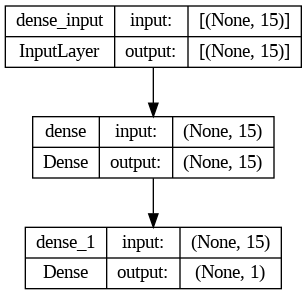

In [ ]:
Result = Rolling_Windows(data=dynmom,
                         window_size=240,
                         method='Fixed',
                         model_name='NN2',
                         epochs=200,
                         batch_size=48,
                         verbose=False)

In [ ]:
display(Result)

In [ ]:
cum_return_sharpe_ratio(Result, WML, 'NN2_PROB_POS_WML')

In [ ]:
plot_result(Result, 'Fixed', 'NN2')

In [ ]:
What_Pred(Result, WML, 'NN2')